# Instacart Market Basket Analysis

In [ ]:
!pip install spark
!pip install pyspark

In [ ]:
import spark
import pyspark

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

This notebook provides a simplified overview of how to perform market basket analysis using a Databricks notebook environment hosted on a private cluster. Using the distributed platform the Databricks provides, we can easily scan and parse large amounts of data very quickly. For this particular problem, the platform is useful for generating large item sets and association rule mining utilizing Apache Spark (MLlib algorithms), PySpark, SQL and Scala.

I will use the Instacart Online Grocery Shopping Dataset from 2017 for this project. Along with the analysis I will explore some of the attributes of the data, producing plots generated in Tableau.

Not shown is the data loaded into a Delta Live Table in Databricks, stored in DBFS and then housed in a an Apache Hive metastore where each file is accesible on its own.

## Create DataFrames

In [ ]:
# import the data
# aisles = spark.read.format("delta").option("header", "true").load("dbfs:/user/hive/warehouse/aisles")
departments = spark.read.format("delta").option("header", "true").load("dbfs:/user/hive/warehouse/departments")
# order_products_prior = spark.read.format("delta").option("header", "true").load("dbfs:/user/hive/warehouse/order_products__prior")
order_products_train = spark.read.format("delta").option("header", "true").load("dbfs:/user/hive/warehouse/order_products_train")
orders = spark.read.format("delta").option("header", "true").load("dbfs:/user/hive/warehouse/orders")
products = spark.read.format("delta").option("header", "true").load("dbfs:/user/hive/warehouse/products")

After importing the data, we need to create something called "temporary tables" (or views) in Spark. These views allow us to treat Spark DataFrames like SQL tables and allows us to use SQL query syntax to filter, transform and analyze our data. Spark SQL is also super fast so that's just an added bonus when dealing with large datasets.

In [ ]:
# Create Temporary Tables
# aisles.createOrReplaceTempView("aisles")
departments.createOrReplaceTempView("departments")
# order_products_prior.createOrReplaceTempView("order_products_prior")
order_products_train.createOrReplaceTempView("order_products_train")
orders.createOrReplaceTempView("orders")
products.createOrReplaceTempView("products")

## Exploratory Data Analysis


### Orders by Day of Week

Now we're going to really tap into the power of using Spark SQL.

First, we'll look at the total amount of orders for each day of the week. The `order_dow` column represents the order day of week in a numerical form so we will do a simple conversion to display the names of the days in our visualization, and then we group by day of week and order by the total amount of orders.

In [ ]:
%sql
select
  count(order_id) as total_orders,
  (case
     when order_dow = '0' then 'Sunday'
     when order_dow = '1' then 'Monday'
     when order_dow = '2' then 'Tuesday'
     when order_dow = '3' then 'Wednesday'
     when order_dow = '4' then 'Thursday'
     when order_dow = '5' then 'Friday'
     when order_dow = '6' then 'Saturday'
   end) as day_of_week
  from orders
group by order_dow
order by total_orders desc

total_orders,day_of_week
600905,Sunday
587478,Monday
467260,Tuesday
453368,Friday
448761,Saturday
436972,Wednesday
426339,Thursday
1,null


Databricks visualization. Run in Databricks to view.

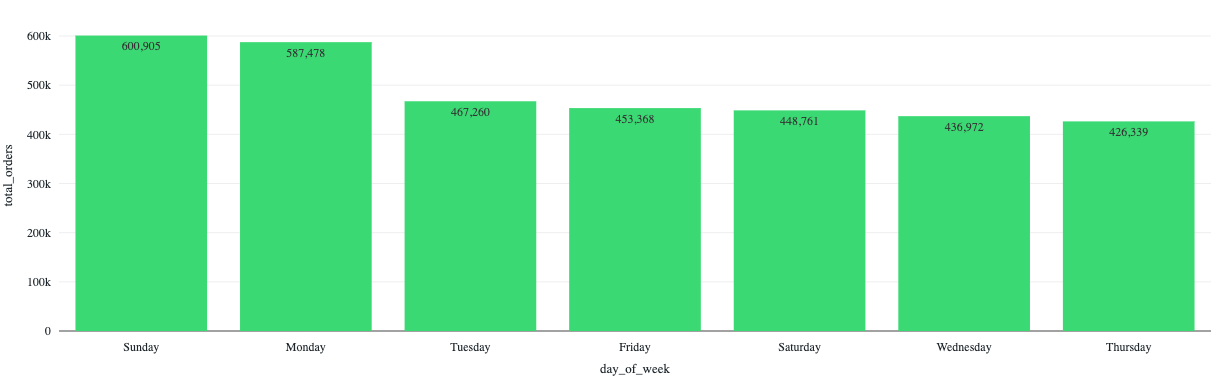

In [2]:
from IPython.display import Image, display
display(Image("./figures/orders_by_day_of_week.png"))

### Orders by Hour

We can also break down the orders by the hour of day that people make their Instacart purchases. As we'll see in the figure, the highest number of orders is usually around 10am and even looks like it stays almost consistently busy up until around 4pm which then it starts to level off.

In [ ]:
%sql
select
  count(order_id) as total_orders,
  order_hour_of_day as hour
from orders
group by order_hour_of_day
order by order_hour_of_day

total_orders,hour
22758,00
12398,01
7539,02
5474,03
5527,04
9569,05
30529,06
91868,07
178201,08
257812,09


Databricks visualization. Run in Databricks to view.

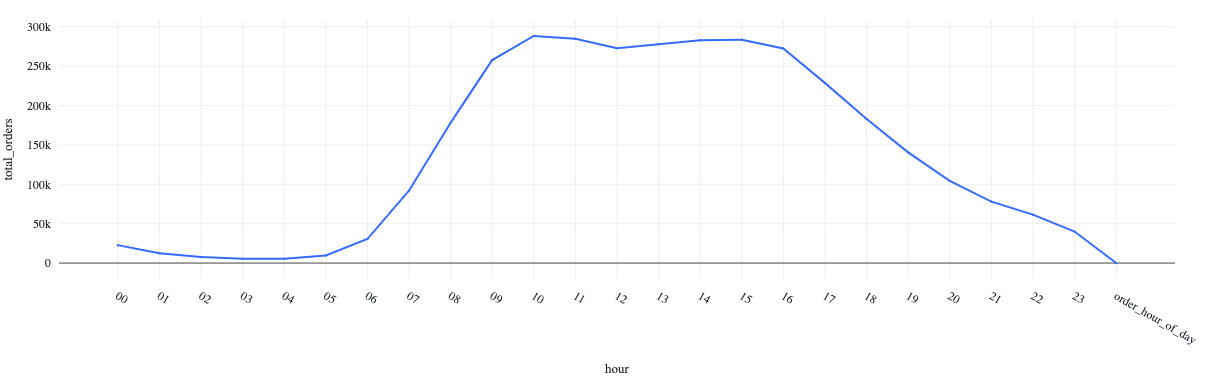

In [3]:
display(Image("./figures/orders_by_hour.png"))

### Understanding what's on the shelves

As we dig deeper into our market basket analysis, we can gain some insight on the number of products by department to understand how much shelf space is being used.

In [ ]:
%sql
select d.department, count(distinct p.product_id) as products
  from products p
    inner join departments d
      on d.department_id = p.department_id
 group by d.department
 order by products desc
 limit 10

department,products
personal care,6563
snacks,6264
pantry,5371
beverages,4365
frozen,4007
dairy eggs,3449
household,3085
canned goods,2092
dry goods pasta,1858
produce,1684


Databricks visualization. Run in Databricks to view.

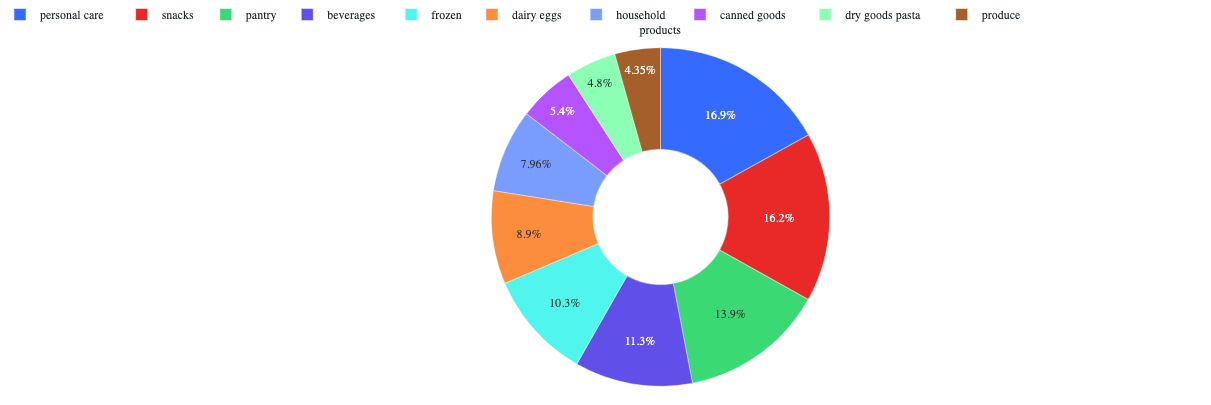

In [4]:
display(Image("./figures/products_by_dept.png"))

It seems like the bulk of unique items (products) involve personal care and snacks.

### Organizing Shopping Baskets

To prepare our data for downstream processing, we'll need to organize our data by shopping basket. In other words, each row in our dataframe represents and `order_id` with each `items` column containing an array of items purchased.

PySpark SQL has some useful functions that will allow us to process our data really quickly after we create our custom `baskets` dataframe from the `products` and `order_products_train` datasets. `collect_set` is just an aggregate function that collects unique values of a column into a set, so here it's collecting all unique product names for each order and puts it into a set. The `alias` function just renames the resulting column to what's specified.

We us `createOrReplaceTempView` on the `baskets` dataset so that we can query it like a SQL table.

In [ ]:
from pyspark.sql.functions import collect_set, col, count

rawData = spark.sql("select p.product_name, o.order_id from products p inner join order_products_train o where o.product_id = p.product_id")
baskets = rawData.groupBy('order_id').agg(collect_set('product_name').alias('items'))
baskets.createOrReplaceTempView('baskets')

### Training the ML Model

To understand the frequency that items are associated with each other, we'll use association rule mining for market basket analysis. The Spark MLlib library implements two algorithms that are related to frequency pattern mining - `FP-growth` and `PrefixSpan`. The difference between the two is that `FP-growth` doesn't use ordered information in the itemsets, and `PrefixSpan` is designed for sequential pattern mining where the itemsets are ordered. We'll use `FP-growth` for this project as the order of our information doesn't really matter to us.

We'll be using Scala for this part of the project since it will calculate our itemsets in much faster time than with pure Python.

In [ ]:
%scala
import org.apache.spark.ml.fpm.FPGrowth

// Extract out the items
val baskets_ds = spark.sql("select items from baskets").as[Array[String]].toDF("items")

// Use FPGrowth
val fpgrowth = new FPGrowth().setItemsCol("items").setMinSupport(0.001).setMinConfidence(0)
val model = fpgrowth.fit(baskets_ds)

// Calculate frequent itemsets
val mostPopularItemInABasket = model.freqItemsets
mostPopularItemInABasket.createOrReplaceTempView("mostPopularItemInABasket")

import org.apache.spark.ml.fpm.FPGrowth
baskets_ds: org.apache.spark.sql.DataFrame = [items: array<string>]
fpgrowth: org.apache.spark.ml.fpm.FPGrowth = fpgrowth_d539a42d1a9d
model: org.apache.spark.ml.fpm.FPGrowthModel = FPGrowthModel: uid=fpgrowth_d539a42d1a9d, numTrainingRecords=131209
mostPopularItemInABasket: org.apache.spark.sql.DataFrame = [items: array<string>, freq: bigint]

With our `mostPopularItemInABasket` dataframe created, we can use Spark SQL to query for the most popular items in a basket where there are more than 2 items.

In [ ]:
%sql
select items, freq from mostPopularItemInABasket where size(items) > 2 order by freq desc limit 20

items,freq
"List(Organic Hass Avocado, Organic Strawberries, Bag of Organic Bananas)",710
"List(Organic Raspberries, Organic Strawberries, Bag of Organic Bananas)",649
"List(Organic Baby Spinach, Organic Strawberries, Bag of Organic Bananas)",587
"List(Organic Raspberries, Organic Hass Avocado, Bag of Organic Bananas)",531
"List(Organic Hass Avocado, Organic Baby Spinach, Bag of Organic Bananas)",497
"List(Organic Avocado, Organic Baby Spinach, Banana)",484
"List(Organic Avocado, Large Lemon, Banana)",477
"List(Limes, Large Lemon, Banana)",452
"List(Organic Cucumber, Organic Strawberries, Bag of Organic Bananas)",424
"List(Limes, Organic Avocado, Large Lemon)",389


From the table above we can see the most frequent purchases of more than two items involve some sort of combination of organic avocados, organic strawberries, and organic bananas. Looking at even just the top 5 results, the most frequently purchased items are a combo of organic avocados, organic strawberries, organic raspberries, organic bananas, and organic baby spinach. From the perspective of recommendations, if a shopper has purchased these items previously, it makes sense to recommend that they purchase them again.

### Association Rules

The model that we created with `FP-growth` also generates `associationRules`, meaning if a shopper purchases cereal, what is the probability that they will also purchase milk.

In [ ]:
%scala

// Display generated association rules
val ifThen = model.associationRules
ifThen.createOrReplaceTempView("ifThen")

ifThen: org.apache.spark.sql.DataFrame = [antecedent: array<string>, consequent: array<string> ... 3 more fields]

Essentially the model determines if you purchased something (called the antecedent), then you will purchase this other thing (the sonsequent) with the following confidence.

Let's take a look at the associations that we have in this dataset. Our assocation rules model is called `ifThen` (i.e. if this - then that)

In [ ]:
%sql
select antecedent as `antecedent (if)`, consequent as `consequent (then)`, confidence from ifThen order by confidence desc limit 20

antecedent (if),consequent (then),confidence
"List(Organic Raspberries, Organic Hass Avocado, Organic Strawberries)",List(Bag of Organic Bananas),0.5984251968503937
"List(Organic Cucumber, Organic Hass Avocado, Organic Strawberries)",List(Bag of Organic Bananas),0.546875
"List(Organic Kiwi, Organic Hass Avocado)",List(Bag of Organic Bananas),0.5459770114942529
"List(Organic Navel Orange, Organic Raspberries)",List(Bag of Organic Bananas),0.5412186379928315
"List(Yellow Onions, Strawberries)",List(Banana),0.5357142857142857
"List(Organic Whole String Cheese, Organic Hass Avocado)",List(Bag of Organic Bananas),0.5314685314685315
"List(Organic Navel Orange, Organic Hass Avocado)",List(Bag of Organic Bananas),0.5283018867924528
"List(Organic Raspberries, Organic Hass Avocado)",List(Bag of Organic Bananas),0.521099116781158
"List(Organic D'Anjou Pears, Organic Hass Avocado)",List(Bag of Organic Bananas),0.5170454545454546
"List(Organic Unsweetened Almond Milk, Organic Hass Avocado)",List(Bag of Organic Bananas),0.5141065830721003


We can see pretty clearly that there is a strong confidence that if a shopper has organic raspberries, organic avocados, or organic strawberries in their basket, then it makes sense to recommend organic bananas as well. If you look a the entire list that was produced above, organic bananas are a strong bet for a purchase recommendation.